In [3]:
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import numpy as np
from datetime import date, datetime
import time
import pymongo
import seaborn as sns


In [2]:
!pip install pandasql

  Using cached https://files.pythonhosted.org/packages/6b/c4/ee4096ffa2eeeca0c749b26f0371bd26aa5c8b611c43de99a4f86d3de0a7/pandasql-0.7.3.tar.gz
  Stored in directory: /Users/flatironschool/Library/Caches/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [49]:
#connect to the database and create a cursor
con = sqlite3.connect('database.sqlite')
cur = con.cursor()

In [50]:
#fecth all the table names
query = """SELECT name FROM sqlite_master
         WHERE type='table'
         ORDER BY name"""

cur.execute(query).fetchall()

[('Matches',),
 ('Teams',),
 ('Teams_in_Matches',),
 ('Unique_Teams',),
 ('sqlite_sequence',)]

In [51]:
#create a dataframe from the db table filtering for 2011 season and German League

matches = cur.execute("""select *
            from Matches 
            where Season = 2011
            AND ((Div = 'D1' OR Div='D2'))""").fetchall()

df_matches = pd.DataFrame(matches)
df_matches. columns = [i[0] for i in cur.description]


dates = df_matches['Date'].unique()

In [53]:
full_df = cur.execute("""
  SELECT
         ut.Unique_Team_ID, ut.TeamName,
                 sum(case
                       when ut.TeamName=m.HomeTeam
                       then m.FTHG
                       end) as goalshome,
               sum( case
                   when ut.TeamName=m.AwayTeam
                   then m.FTAG
                   else 0
                   end) as goalsaway,
               count(case
                    when ut.TeamName=m.HomeTeam
                    and m.FTR='H'
                    then 1 else NULL END
                    ) as homewins,
               count(case
                    when ut.TeamName=m.HomeTeam
                    and m.FTR='A'
                    then 1 else NULL END
                     ) as homelosses,
               count(case
                    when ut.TeamName=m.AwayTeam
                    and m.FTR='A'
                    then 1 else NULL END
                    ) as awaywis,
               count(case
                     when ut.TeamName=m.AwayTeam
                     and m.FTR='H'
                     then 1 else NULL END
                     ) as awaylosses
               from Unique_Teams ut
                   join Teams_in_Matches tm
                       on ut.Unique_Team_ID=tm.Unique_Team_ID
                   join Matches m
                       on m.Match_ID=tm.Match_ID
               where m.Season = 2011
                   and ((Div = 'D1' OR Div='D2'))
               group by ut.Unique_Team_ID
               order by ut.TeamName;
""").fetchall()


## 1. The name of the team

In [5]:
team_names = cur.execute(""" SELECT *
                FROM Unique_Teams
                """).fetchall()


In [6]:
team_names = pd.DataFrame(team_names)
team_names.columns = [i[0] for i in cur.description]

In [7]:
team_names['TeamName'].head()

0    Bayern Munich
1         Dortmund
2       Leverkusen
3       RB Leipzig
4       Schalke 04
Name: TeamName, dtype: object

## 2. The total number of goals scored by the team during the 2011 season

In [8]:
#make two tables, one for the hometeams goals and awayteams goals and then merge them

home = cur.execute("""SELECT HomeTeam as team, sum(FTHG) as home
                FROM Matches
                WHERE Season = 2011
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY HomeTeam""").fetchall()


home_df = pd.DataFrame(home)
home_df.columns = [i[0] for i in cur.description]

away = cur.execute("""SELECT AwayTeam as team, sum(FTAG) as away 
                FROM Matches
                WHERE Season =2011
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY AwayTeam""").fetchall()
away_df = pd.DataFrame(away)
away_df.columns = [i[0] for i in cur.description]


In [9]:
#merge the two dataframes above into one table and create a new column for the total number of goals

goals_df= pd.merge(away_df, home_df, on='team')

goals_df['total_goals'] = goals_df['home']+ goals_df['away']

goals_df.head()

,team,away,home,total_goals
0,Aachen,15,15,30
1,Augsburg,16,20,36
2,Bayern Munich,28,49,77
3,Bochum,18,23,41
4,Braunschweig,16,21,37


## 3. The total number of wins the team earned during the 2011 season

In [10]:
#create a table for each combination, home team-win, home team-losses, away team-win, away team-losses

homewin = cur.execute("""SELECT HomeTeam as team, count(FTR) as homewin
                FROM Matches
                WHERE Season = 2011
                AND FTR='H'
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY HomeTeam""").fetchall()


homewin_df = pd.DataFrame(homewin)
homewin_df.columns = [i[0] for i in cur.description]


homewin_df.head()

,team,homewin
0,Aachen,4
1,Augsburg,6
2,Bayern Munich,14
3,Bochum,7
4,Braunschweig,6


In [11]:
homeloss = cur.execute("""SELECT HomeTeam as team, count(FTR) as homeloss 
                FROM Matches
                WHERE Season = 2011
                AND FTR='A'
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY HomeTeam""").fetchall()


homeloss_df = pd.DataFrame(homeloss)
homeloss_df.columns = [i[0] for i in cur.description]


homeloss_df.head()

,team,homeloss
0,Aachen,7
1,Augsburg,4
2,Bayern Munich,2
3,Bochum,7
4,Braunschweig,3


In [12]:
awaywin = cur.execute("""SELECT AwayTeam as team, count(FTR) as awaywin
                FROM Matches
                WHERE Season =2011
                AND FTR='A'
                AND NOT Div='E0'
                GROUP BY AwayTeam""").fetchall()

awaywin_df = pd.DataFrame(awaywin)
awaywin_df.columns = [i[0] for i in cur.description]

awaywin_df.head()

,team,awaywin
0,Aachen,2
1,Augsburg,2
2,Bayern Munich,9
3,Bochum,3
4,Braunschweig,4


In [13]:
awayloss = cur.execute("""SELECT AwayTeam as team, count(FTR) as awayloss
                FROM Matches
                WHERE Season =2011
                AND FTR='H'
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY AwayTeam""").fetchall()

awayloss_df = pd.DataFrame(awayloss)
awayloss_df.columns = [i[0] for i in cur.description]

awayloss_df.head()

,team,awayloss
0,Aachen,8
1,Augsburg,8
2,Bayern Munich,5
3,Bochum,10
4,Braunschweig,6


In [14]:
wins_df= pd.merge(awaywin_df, homewin_df, on='team')

wins_df['totalwin'] = wins_df['homewin']+ wins_df['awaywin']
wins_df.head()


,team,awaywin,homewin,totalwin
0,Aachen,2,4,6
1,Augsburg,2,6,8
2,Bayern Munich,9,14,23
3,Bochum,3,7,10
4,Braunschweig,4,6,10


In [15]:
loss_df= pd.merge(awayloss_df, homeloss_df, on='team')

loss_df['totaloss'] = loss_df['homeloss']+ loss_df['awayloss']

loss_df.head()

,team,awayloss,homeloss,totaloss
0,Aachen,8,7,15
1,Augsburg,8,4,12
2,Bayern Munich,5,2,7
3,Bochum,10,7,17
4,Braunschweig,6,3,9


In [16]:
totalwinloss = pd.merge(wins_df, loss_df, on='team', how='left')

In [17]:
totalwinloss.head()

,team,awaywin,homewin,totalwin,awayloss,homeloss,totaloss
0,Aachen,2,4,6,8.0,7.0,15.0
1,Augsburg,2,6,8,8.0,4.0,12.0
2,Bayern Munich,9,14,23,5.0,2.0,7.0
3,Bochum,3,7,10,10.0,7.0,17.0
4,Braunschweig,4,6,10,6.0,3.0,9.0


## 4. A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)

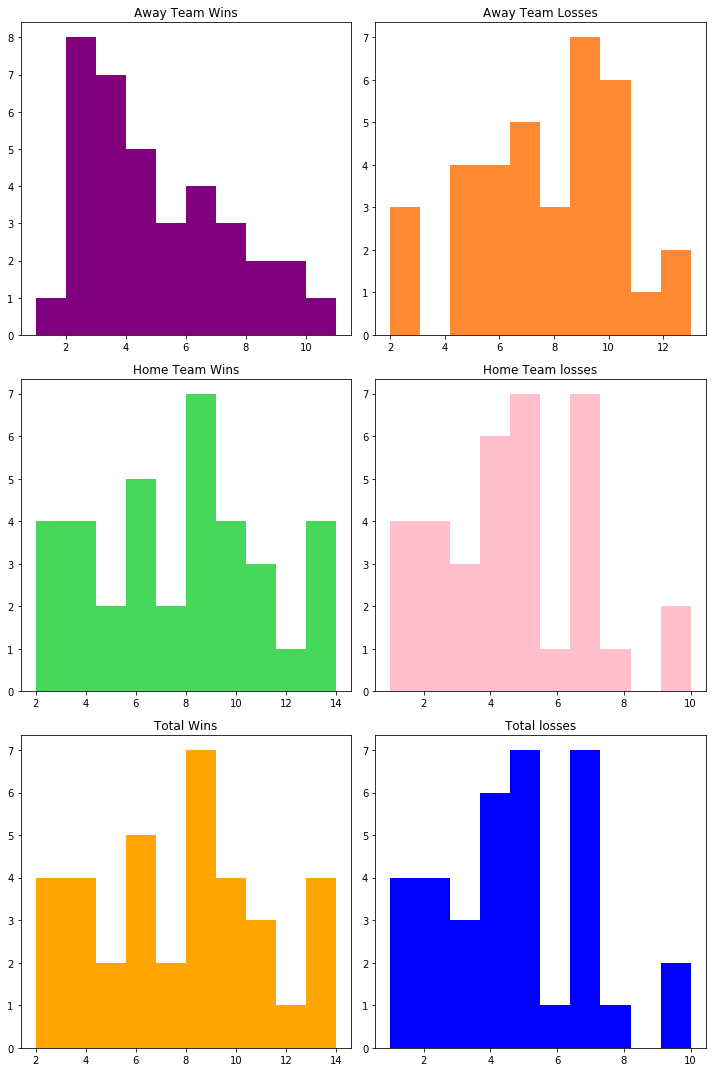

<Figure size 432x288 with 0 Axes>

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()


ax0.hist(totalwinloss['awaywin'], bins = 10, color='purple')
ax0.set_title('Away Team Wins')

ax1.hist(totalwinloss['awayloss'],bins = 10,  color='#ff8a33')
ax1.set_title('Away Team Losses')

ax2.hist(totalwinloss['homewin'], bins = 10, color='#47D85B')
ax2.set_title('Home Team Wins')

ax3.hist(totalwinloss['homeloss'],bins = 10,  color='pink')
ax3.set_title('Home Team losses')

ax4.hist(totalwinloss['homewin'], bins = 10, color='orange')
ax4.set_title('Total Wins')

ax5.hist(totalwinloss['homeloss'],bins = 10,  color='blue')
ax5.set_title('Total losses')

fig.tight_layout()
plt.show()

plt.savefig('histograms.png')

### API: Weather Data

In [19]:
!pip install python-dotenv

In [20]:
# lat 52.5200, long 13.4050 for Berlin
# API data format [YYYY]-[MM]-[DD]T[HH]:[MM]:[SS][timezone]. timezone

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os

load_dotenv()

class WeatherGetter():

    def __init__(self):
        # Let's set our secrets and keys from the .env file
        # as environment variables.
        self.BASE_URL = 'https://api.darksky.net'
        self.token = os.getenv('DARKSKY_KEY')

        if len(self.token) == 0:
            raise ValueError('Missing API key!')
    
    def getForecast(self, date=list):
        weather_dates={}

        for date in dates_list:
            weather = requests.get(f'https://api.darksky.net/forecast/{self.token}/52.5200, 13.4050, {date}').json()
            weather_like = weather['currently']['summary']
            weather_dates[date] = weather_like
    
        return weather_dates

In [21]:
unique = df_matches['Date'].unique()

dates_list = []

for datetime in unique:
    dates_list.append(datetime + "T20:00:00")
    
len(dates_list)

136

In [22]:
#create a class instance 
call=WeatherGetter()

In [23]:
#call the calss method 
weather_dates = call.getForecast(dates_list)

In [24]:
#get the json result into a dataframe
weather_df = pd.DataFrame(list(weather_dates.items()), columns=['date', 'DateValue'])

In [44]:
#to simplify the merge I create a new column that matches the date format in the json file
df_matches['date']= df_matches['Date'].map(lambda x: x + "T20:00:00")

In [26]:
matches_weather_df = pd.merge(df_matches, weather_df, on='date')

In [27]:
matches_weather_df['DateValue'].unique()

array(['Mostly Cloudy', 'Clear', 'Partly Cloudy', 'Possible Light Rain',
       'Possible Drizzle', 'Overcast', 'Light Rain', 'Foggy', 'Rain'],
      dtype=object)

In [28]:
matches_weather_df['rain'] = matches_weather_df['DateValue'].apply(lambda x: 1 if x=='Rain' else (1 if x=='Light Rain' else 0) )

In [29]:
matches_weather_df['rain_home_win'] =np.where(np.logical_and(matches_weather_df['FTR']=='H',matches_weather_df['rain']==1),1,0)

In [30]:
matches_weather_df['rain_away_win'] =np.where(np.logical_and(matches_weather_df['FTR']=='H',matches_weather_df['rain']==1),1,0)

In [31]:
hometeam = matches_weather_df.groupby(['HomeTeam']).sum()

hometeam['Team']= hometeam.index

home = hometeam.loc[:,['Team','rain_home_win', 'rain']]

In [32]:
awayteam = matches_weather_df.groupby(['AwayTeam']).sum()
awayteam['Team']= hometeam.index
away = awayteam.loc[:,['Team', 'rain_away_win','rain']]

In [33]:
rain_wins = pd.merge(away, home, on ='Team')

In [34]:
rain_wins.groupby('Team').sum()

rain_wins['total']=rain_wins['rain_home_win']+rain_wins['rain_away_win']

rain_wins['total_rain'] = rain_wins['rain_x']+rain_wins['rain_y']

In [35]:
per_win = rain_wins.groupby('Team').sum()

per_win['percentage'] = per_win['total']/per_win['total_rain']

In [36]:
per_win['team'] = per_win.index

## From DataFrame to MongoDB

In [2]:
mongodata = pd.merge(totalwinloss,per_win, on='team')

NameError: name 'pd' is not defined

In [38]:
mymongo = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

In [39]:
mymongo

MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True)

In [40]:
mydb = mymongo['teams_data']

In [41]:
mycollection = mydb['myteams']

In [42]:
mydict = list(mongodata.to_dict(orient='records'))


In [43]:
mycollection.insert_many(mydict)

In [1]:
!jupyter nbconvert --to script mod_2.ipynb

[NbConvertApp] Converting notebook mod_2.ipynb to script
[NbConvertApp] Writing 10203 bytes to mod_2.py
